In [1]:
import torch
import json
from transformers import CLIPTokenizer,CLIPTextModel

C:\Users\vishw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
from torch.utils.data import Dataset
from torchvision.transforms import transforms
from PIL import Image

transform = transforms.Compose([
                                transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                                ])

class CocoWithAnnotations(Dataset):
    def __init__(self,path,tokenizer,text_model,transform,train=True):
        super().__init__()
        self.path = path
        self.data = None
        self.transform = transform
        self.tokenizer = tokenizer
        self.text_model = text_model
        self.train = train
        if self.data is None:
            self.open_json()
    
    def open_json(self):
        if self.train:
            print('======================= Loading training annotations =======================')
            with open(f'{self.path}/annotations/captions_train2014.json','r+') as stream:
                self.data = json.load(stream)
            self.data = self.data['annotations']
        else:
            print('======================= Loading validation annotations =======================')
            with open(f'./{self.path}/annotations/captions_val2014.json','r+') as stream:
                self.data = json.load(stream)
            self.data = self.data['annotations']
        print('======================= ANNOTATIONS LOADED =======================')
        
    def __getitem__(self, index):
        annot = self.data[index]
        image_id =str(annot["image_id"]).zfill(6)
        image = self.transform(Image.open(f'{self.path}/train2014/COCO_train2014_000000{image_id}.jpg'))
        tokens = self.tokenizer(annot['caption'], padding="max_length", truncation=True, max_length=77, return_tensors="pt")
        text_embs = self.text_model(**tokens).last_hidden_state
        return image,text_embs.squeeze(0)
        

In [47]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# Define alpha values (cumulative product of 1 - beta)
def compute_alpha_cumprod(beta_schedule):
    alpha = 1.0 - beta_schedule
    alpha_cumprod = torch.cumprod(alpha, dim=0)
    return alpha_cumprod

# Define timesteps and compute schedule
timesteps = 1000
beta_schedule = linear_beta_schedule(timesteps)
alpha_cumprod = compute_alpha_cumprod(beta_schedule)

In [48]:


tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
clip_text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

dataset = CocoWithAnnotations('./coco',tokenizer,clip_text_model,transform)

# Example text
captions = "a black and white cat in a basket on a sofa"

# Tokenize text (output has input IDs and attention masks)
tokenized_captions = tokenizer(captions, padding="max_length", truncation=True, max_length=77, return_tensors="pt")

# Extract text embeddings
text_embeddings = clip_text_model(**tokenized_captions).last_hidden_state

======================= Loading training annotations =======================
======================= ANNOTATIONS LOADED =======================


In [ ]:
dataset[0]


(tensor([[[-0.6078, -0.6157, -0.6157,  ..., -0.6627, -0.7569, -0.6863],
          [-0.6000, -0.6157, -0.6078,  ..., -0.3647, -0.5922, -0.6784],
          [-0.5843, -0.6078, -0.6157,  ..., -0.4745, -0.5608, -0.6706],
          ...,
          [-0.0039, -0.0039,  0.0196,  ..., -0.1451, -0.1608, -0.1765],
          [-0.0431, -0.0431, -0.0275,  ..., -0.1686, -0.1843, -0.1922],
          [-0.0431, -0.0431, -0.0353,  ..., -0.1922, -0.2078, -0.2235]],
 
         [[-0.3569, -0.3569, -0.3490,  ..., -0.6157, -0.6863, -0.5843],
          [-0.3333, -0.3255, -0.3176,  ..., -0.3647, -0.5686, -0.5608],
          [-0.3176, -0.2941, -0.2863,  ..., -0.4510, -0.5451, -0.5765],
          ...,
          [-0.0275, -0.0353, -0.0275,  ..., -0.1843, -0.2000, -0.2000],
          [-0.0667, -0.0667, -0.0588,  ..., -0.2157, -0.2235, -0.2314],
          [-0.0667, -0.0667, -0.0588,  ..., -0.2314, -0.2471, -0.2471]],
 
         [[-0.1529, -0.1373, -0.1294,  ..., -0.5765, -0.5922, -0.5373],
          [-0.0980, -0.1137,

In [51]:
def visualize(dataset_cell):
    import matplotlib.pyplot as plt
    inv_transform = transforms.Compose([
        transforms.Normalize(mean=[-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5], std=[1 / 0.5, 1 / 0.5, 1 / 0.5]),
        transforms.ToPILImage(),
    ])

    image = inv_transform(dataset_cell[0])

    plt.imshow(image)

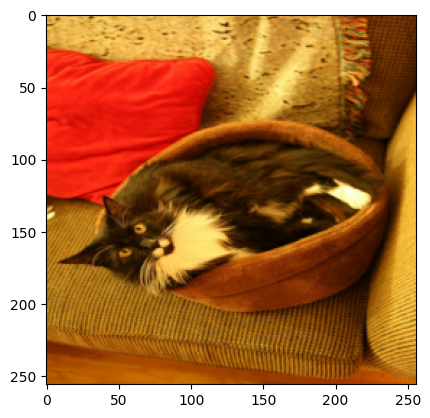

In [52]:
visualize(dataset[139192])